

# Project: An investigation into a TMDB dataset

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> For this project I have chosen to look at the TMDB dataset. For this project I chose the TMDB dataset. Because data comes from kaggle and I have a lot of information.
 Questions:
 1. Which genres are most poular from year to year?
 2. What kinds of properties are associated with movies that have high revenues?

In [2]:
import pandas as pd
import numpy as np
% matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

pd.options.display.float_format = '{:20,.2f}'.format


<a id='wrangling'></a>
## Data Wrangling

### General Properties

In [3]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
movies = pd.read_csv('tmdb-movies.csv')

In [4]:
#High level of view of the dataset
#In this section i'll take an initial view of the data - this will also include the number of rows, the datatype and the number of non-null values in those columns.
#I'll also take a look at the number of uniqeue values for those colunmns.

In [5]:
movies.head()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.99,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.50,2015,"137,999,939.28","1,392,445,892.52"
1,76341,tt1392190,28.42,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.10,2015,"137,999,939.28","348,161,292.49"
2,262500,tt2908446,13.11,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.30,2015,"101,199,955.47","271,619,025.41"
3,140607,tt2488496,11.17,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/15,5292,7.50,2015,"183,999,919.04","1,902,723,129.80"
4,168259,tt2820852,9.34,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/15,2947,7.30,2015,"174,799,923.09","1,385,748,801.47"


In [6]:
df.info()

NameError: name 'df' is not defined

In [7]:
#The next cell was used to sort by differenct columns names

In [8]:
df.sort_values(by=['vote_count'], ascending=False)

NameError: name 'df' is not defined

In [9]:
# A view of the number of unique values in the columns

In [10]:
df.nunique()

NameError: name 'df' is not defined

In [11]:
#Confirm ambigous datatype
#A confirmation of the datatypes for all columns described above as 'object'.

In [12]:
print("I am imdb_id: ", type(df['imdb_id'][0]))
print("I am original_title: ", type(df['original_title'][0]))
print("I am cast: ", type(df['cast'][0]))
print("I am homepage: ", type(df['homepage'][0]))
print("I am director: ", type(df['director'][0]))
print("I am tagline: ", type(df['tagline'][0]))
print("I am keywords: ", type(df['keywords'][0]))
print("I am overview: ", type(df['overview'][0]))
print("I am genres: ", type(df['genres'][0]))
print("I am production_companies: ", type(df['production_companies'][0]))
print("I am release_date: ", type(df['release_date'][0]))

NameError: name 'df' is not defined

In [13]:
#Initial thoughts on the data so far
#Null Values
#While looking at null rows, I noticed that a number of columns have 0:
#popularity
#budget
#revenue
#runtime
#budget_adj
#revenue_adj
#Uniques
#For columns like 'id' and 'original_title' I would expect these to be unique all the way through. A closer inspection of these rows is needed to decide on the action.
#Datatypes
#On the face of it, the only real issue is with release_date. For proper interogation, this will need converting from a string to a datetime object.

In [14]:
#this section will look at the several hundred film title dupes and the single ID duplication.
#create an extra column and mark a row as True where a duplicate itle is found
movies['is_duplicate_title'] = movies.duplicated(['original_title'])

In [15]:
#filter anything that is True
movies_dupe_title_filter = movies[movies['is_duplicate_title'] == True]

In [16]:
movies_dupe_title_filter

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,is_duplicate_title
1133,281778,tt3297792,0.19,0,0,Survivor,Danielle Chuchran|Kevin Sorbo|Rocky Myers|Ruby...,http://www.arrowstormentertainment.com/#!survi...,John Lyde,Alone. Stranded. Deadly,...,93,Science Fiction|Action|Fantasy,Arrowstorm Entertainment,7/22/14,23,4.90,2014,0.00,0.00,True
1194,296626,tt3534842,0.13,0,0,Finders Keepers,Jaime Pressly|Kylie Rogers|Tobin Bell|Patrick ...,NaN,Alexander Yellen,NaN,...,85,Mystery|Thriller|Horror,HFD Productions|Hybrid LLC,10/18/14,33,4.80,2014,0.00,0.00,True
1349,42222,tt0076245,0.40,0,0,Julia,Jane Fonda|Vanessa Redgrave|Jason Robards|Maxi...,NaN,Fred Zinnemann,"Through It All, Friendship Prevailed.",...,117,Drama,Twentieth Century Fox Film Corporation,10/2/77,10,5.00,1977,0.00,0.00,True
1440,7445,tt0765010,1.22,26000000,43318349,Brothers,Tobey Maguire|Jake Gyllenhaal|Natalie Portman|...,NaN,Jim Sheridan,There are two sides to every family.,...,104,Drama|Thriller|War,Lionsgate|Relativity Media|Sighvatsson Films|M...,1/27/09,381,6.70,2009,"26,426,411.29","44,028,788.73",True
1513,62320,tt1014762,0.69,0,0,Home,Glenn Close|Yann Arthus-Bertrand|Jacques Gambl...,http://www.homethemovie.org/,Yann Arthus-Bertrand,A Stunning Visual Portrayal of Earth,...,95,Documentary,Europa Corp.|ElzÃ©vir Films|France 2 (FR2),6/3/09,109,7.80,2009,0.00,0.00,True
1707,79896,tt1336006,0.31,0,0,The Revenant,Chris Wylde|David Anders|Louise Griffiths|Jacy...,http://www.therevenantmovie.com/,D. Kerry Prior,What could be worse than having your best frie...,...,110,Comedy|Horror,Putrefactory Limited|Wanko Toys,8/16/09,30,5.50,2009,0.00,0.00,True
1753,36465,tt0992993,0.25,0,0,Into the Storm,Brendan Gleeson|Iain Glen|James D'Arcy|Janet M...,http://www.hbo.com/movies/into-the-storm/index...,Thaddeus O'Sullivan,NaN,...,100,Drama|History|Foreign,NaN,5/31/09,13,5.80,2009,0.00,0.00,True
1757,21398,tt1220213,0.32,5000000,0,Grace,Jordan Ladd|Samantha Ferris|Gabrielle Rose|Ste...,NaN,Paul Solet,Love. Undying.,...,94,Horror|Thriller,ArieScope Pictures|Dark Eye Entertainment|Leom...,8/14/09,21,4.90,2009,"5,082,002.17",0.00,True
1865,220903,tt1533395,0.10,0,0,Life,David Attenborough|Oprah Winfrey,http://www.bbc.co.uk/programmes/b00lbpcy,Martha Holmes|Simon Blakeney|Stephen Lyle,From the Makers of Planet Earth,...,500,Documentary,British Broadcasting Corporation (BBC),12/14/09,24,7.00,2009,0.00,0.00,True
2036,41505,tt1179069,0.79,22000000,851517,Shelter,Julianne Moore|Jonathan Rhys Meyers|Jeffrey De...,http://www.shelter-movie.jp/index.html,BjÃ¶rn Stein|MÃ¥ns MÃ¥rlind,Evil will rise.,...,112,Horror|Mystery|Thriller,NALA Films|IM Global|Maraci/Edelstein Films|Sh...,3/27/10,112,5.50,2010,"22,000,000.00","851,517.00",True


In [17]:
movies_title_check = movies[movies['original_title'] == 'Robin Hood']
movies_title_check.head()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,is_duplicate_title
1938,20662,tt0955308,2.12,200000000,310669540,Robin Hood,Russell Crowe|Cate Blanchett|Mark Strong|Oscar...,http://www.robinhoodthemovie.com/,Ridley Scott,"Rise and rise again, until lambs become lions.",...,140,Action,Imagine Entertainment|Universal Pictures|Scott...,5/12/10,844,6.10,2010,"200,000,000.00","310,669,540.00",False
10593,11886,tt0070608,2.27,15000000,32056467,Robin Hood,Brian Bedford|Phil Harris|Peter Ustinov|Pat Bu...,NaN,Wolfgang Reitherman,Meet Robin Hood and his MERRY MENagerie!,...,83,Animation|Family,Walt Disney Productions,11/8/73,641,6.90,1973,"73,667,393.68","157,434,424.97",True


In [18]:
#Upon inspection, it seems that duplicate film titles can be considered different films that have the same name.

#The same process is applied for the duplicate ID. Since there is only one duplicate ID, there is no need to create a csv.

In [19]:
movies['is_duplicate_id'] = movies.duplicated(['id'])

In [20]:
movies_dupe_id_filter = movies[movies['is_duplicate_id'] == True]

In [21]:
movies_dupe_id_filter.head()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,is_duplicate_title,is_duplicate_id
2090,42194,tt0411951,0.60,30000000,967000,TEKKEN,Jon Foo|Kelly Overton|Cary-Hiroyuki Tagawa|Ian...,NaN,Dwight H. Little,Survival is no game,...,Crime|Drama|Action|Thriller|Science Fiction,Namco|Light Song Films,3/20/10,110,5.00,2010,"30,000,000.00","967,000.00",True,True


In [22]:
movies_id_check_dupe = movies[movies['id'] == 42194]
movies_id_check_dupe.head()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,is_duplicate_title,is_duplicate_id
2089,42194,tt0411951,0.60,30000000,967000,TEKKEN,Jon Foo|Kelly Overton|Cary-Hiroyuki Tagawa|Ian...,NaN,Dwight H. Little,Survival is no game,...,Crime|Drama|Action|Thriller|Science Fiction,Namco|Light Song Films,3/20/10,110,5.00,2010,"30,000,000.00","967,000.00",False,False
2090,42194,tt0411951,0.60,30000000,967000,TEKKEN,Jon Foo|Kelly Overton|Cary-Hiroyuki Tagawa|Ian...,NaN,Dwight H. Little,Survival is no game,...,Crime|Drama|Action|Thriller|Science Fiction,Namco|Light Song Films,3/20/10,110,5.00,2010,"30,000,000.00","967,000.00",True,True


In [23]:
#Now that I have the duplicate ID (and given that the original_title duplicates appear to be different films with the same title), 
#this is a final sense check to make sure the entire row is a duplicate:
movies.drop_duplicates(subset=['id'],inplace=True)



### Data Cleaning 


Drop columns:
In this section, I've decided to drop columns that are extraneous to both questions in the analysis:

imdb_id: this appears to relate to the previous IMDB data. Assumption is that this was left in by Kaggle to map the IMDB and TMDB ids together

budget and revenue: since budget_adj and revenue_adj have already been normalised to 2010 levels for more direct comparision, these two columns are no longer required

homepage, tagline, overview and keywords: seem unnecessary to include this for the type of intended analysis

is_duplicate_title: is no longer necessary

is_duplicate_id: is no longer necessary

In [24]:
movies.drop(['imdb_id', 'budget', 'revenue', 'homepage', 'tagline', 'overview', 'keywords', 'is_duplicate_title', 'is_duplicate_id'], axis=1, inplace=True)

In [25]:
movies.head()

,id,popularity,original_title,cast,director,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,32.99,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.50,2015,"137,999,939.28","1,392,445,892.52"
1,76341,28.42,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,George Miller,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.10,2015,"137,999,939.28","348,161,292.49"
2,262500,13.11,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,Robert Schwentke,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.30,2015,"101,199,955.47","271,619,025.41"
3,140607,11.17,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,J.J. Abrams,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/15,5292,7.50,2015,"183,999,919.04","1,902,723,129.80"
4,168259,9.34,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,James Wan,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/15,2947,7.30,2015,"174,799,923.09","1,385,748,801.47"


<a id='eda'></a>
Update the datatypes

This section will look to change the release_date from a string to a datetime object.

In [26]:
movies['release_date'] = pd.to_datetime(movies['release_date'])

In [27]:
type(movies['release_date'][0])

pandas._libs.tslibs.timestamps.Timestamp

<a id='eda'></a>
Deal with null values
This section will look to drop rows with null values. For runtime, budget_adj and revenue_adj, 0 values are also considered null.

For the first 'Genres' based question in the introduction, I will look create a dataframe that cleans out null genres, and drops extraneous columns. This should return me the most number of intact rows suitable for that exploration.

For the question that looks at the types of properties associcated with high revenue movies, I will wish to keep some of the dropped columns for that analysis - therefore, I will use a separate dataframe. and then clean out the 0 values for budget_adj and revenue_adj.

<a id='eda'></a>
## Exploratory Data Analysis


### Research Question 1 (Which genres are most popular from year to year?)

In [28]:

#In this section we will look to address the question: "Which genres are the most popular from year to year?". To approach this, we need to set some definitions:

#Popularity: TMDB have an aggregated metric, popularity, which combines a number of aspects as defined here, in their API documentation.
#Most popular: at what point do we consider a genre to be a threshold to be termed most popular?

In [29]:
movie_genres = movies.copy()
movie_genres.drop(['original_title', 'cast', 'director', 'runtime', 'release_date', 'production_companies', 'vote_count', 'vote_average','budget_adj', 'revenue_adj'], axis=1, inplace=True)
movie_genres.head(1)

,id,popularity,genres,release_year
0,135397,32.99,Action|Adventure|Science Fiction|Thriller,2015


In [30]:
# drop NaN values - only targets genres at this stage
movie_genres.dropna(axis=0, how='any', inplace=True)

<a id='eda'></a>
Some of the rows in the genres column hold a multiple values. To begin using the information in this column effectively, I need to:

know how many unique genres labels there are; and
split these genres out into such a way that they can be considered individually
The next set of cells will address this.

In [31]:
genre = movie_genres.loc[:, ['id', 'genres']]
genre.head(5)

,id,genres
0,135397,Action|Adventure|Science Fiction|Thriller
1,76341,Action|Adventure|Science Fiction|Thriller
2,262500,Adventure|Science Fiction|Thriller
3,140607,Action|Adventure|Science Fiction|Fantasy
4,168259,Action|Crime|Thriller


In [32]:
genre_list = genre['genres'].str.split('|').tolist()
genre_list[:5]

[['Action', 'Adventure', 'Science Fiction', 'Thriller'],
 ['Action', 'Adventure', 'Science Fiction', 'Thriller'],
 ['Adventure', 'Science Fiction', 'Thriller'],
 ['Action', 'Adventure', 'Science Fiction', 'Fantasy'],
 ['Action', 'Crime', 'Thriller']]

<a id='eda'></a>
The next set of code cells will look to bring this list back into a useable dataframe. (The very first code cell was added retrospectively to correct an error with the successive code cell).

In [33]:
for i in range(len(genre_list)):
    if not isinstance(genre_list[i], list):
        genre_list[i] = [genre_list[i]]

In [34]:
stacked_genre = pd.DataFrame(genre_list, index=genre['id']).stack()

In [35]:
print(stacked_genre.head())

id       
135397  0             Action
        1          Adventure
        2    Science Fiction
        3           Thriller
76341   0             Action
dtype: object


In [36]:
stacked_genre = stacked_genre.reset_index()

In [37]:
print(stacked_genre.head())

       id  level_1                0
0  135397        0           Action
1  135397        1        Adventure
2  135397        2  Science Fiction
3  135397        3         Thriller
4   76341        0           Action


In [38]:
stacked_genre = stacked_genre.loc[:, ['id', 0]]

In [39]:
print(stacked_genre.head())

       id                0
0  135397           Action
1  135397        Adventure
2  135397  Science Fiction
3  135397         Thriller
4   76341           Action


In [40]:
stacked_genre.columns = ['id', 'genre']

In [41]:
print(stacked_genre.head())

       id            genre
0  135397           Action
1  135397        Adventure
2  135397  Science Fiction
3  135397         Thriller
4   76341           Action


In [42]:
merged_df = pd.merge(movie_genres, stacked_genre, on='id', how='left')
merged_df.drop(['genres', 'id'], axis=1, inplace=True)

In [43]:
merged_df.head()

,popularity,release_year,genre
0,32.99,2015,Action
1,32.99,2015,Adventure
2,32.99,2015,Science Fiction
3,32.99,2015,Thriller
4,28.42,2015,Action


<a id='eda'></a>
We can see from the above dataframe snippet that we have broken out the genres against the release year and popularity values.

Text(0.5,0,'Genre')

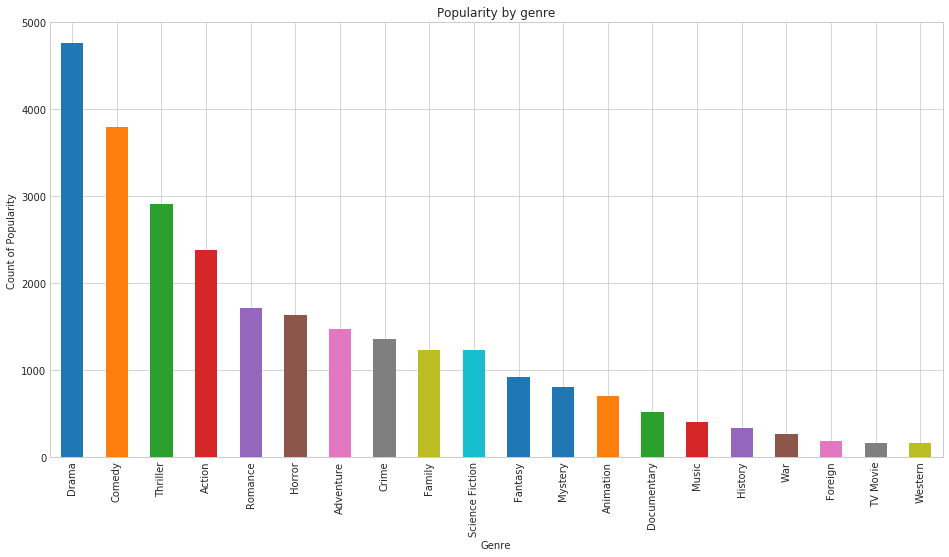

In [69]:
merged_df['genre'].value_counts().plot(kind='bar', figsize=(16, 8));
plt.title('Popularity by genre')
plt.ylabel('Count of Popularity')
plt.xlabel('Genre')

<a id='eda'></a>
From the above chart, we can see all the different genre types and the frequency in which that type occurs in the data. The next process is to consider how to organise the data to

To do this, we take the genres and group by the release year while calculating the mean popularity in that group. That way we can view the relationship between annual average popularity per genre across the years available.

In [45]:
def group_years(genre_name):
    # filter for the genre value that we are targetting;
    # makes a copy df so that pandas doesn't issue a 
    # warning on the next operation
  
    genre = merged_df[merged_df['genre'] == genre_name].copy()
    # drop the genre column as it's now extraneous
    genre.drop(['genre'], axis=1, inplace=True)
    # group by release_year and calculate the mean
    popularity_mean = genre.groupby(['release_year']).mean().reset_index()
    # rename the popularity column to include the genre name
    popularity_mean.rename(columns={'popularity':'popularity_' + genre_name.lower()}, inplace=True)
    return popularity_mean

In [46]:
# run the function against all the genre columns
# and store against a variable
drama_popularity = group_years('Drama')
comedy_popularity = group_years('Comedy')
thriller_popularity = group_years('Thriller')
action_popularity = group_years('Action')
romance_popularity = group_years('Romance')
horror_popularity = group_years('Horror')
adventure_popularity = group_years('Adventure')
crime_popularity = group_years('Crime')
family_popularity = group_years('Family')
scifi_popularity = group_years('Science Fiction')
fantasy_popularity = group_years('Fantasy')
mystery_popularity = group_years('Mystery')
animation_popularity = group_years('Animation')
documentary_popularity = group_years('Documentary')
music_popularity = group_years('Music')
history_popularity = group_years('History')
war_popularity = group_years('War')
foreign_popularity = group_years('Foreign')
tv_popularity = group_years('TV Movie')
western_popularity = group_years('Western')

#merge all of the above into a new dataframe to plot the lines.

In [47]:
# Step through and merge each one in turn into a single df
genre_merge = pd.merge(drama_popularity, comedy_popularity, on='release_year', how='left')
genre_merge = pd.merge(genre_merge, thriller_popularity, on='release_year', how='left')
genre_merge = pd.merge(genre_merge, action_popularity, on='release_year', how='left')
genre_merge = pd.merge(genre_merge, romance_popularity, on='release_year', how='left')
genre_merge = pd.merge(genre_merge, horror_popularity, on='release_year', how='left')
genre_merge = pd.merge(genre_merge, adventure_popularity, on='release_year', how='left')
genre_merge = pd.merge(genre_merge, crime_popularity, on='release_year', how='left')
genre_merge = pd.merge(genre_merge, family_popularity, on='release_year', how='left')
genre_merge = pd.merge(genre_merge, scifi_popularity, on='release_year', how='left')
genre_merge = pd.merge(genre_merge, fantasy_popularity, on='release_year', how='left')
genre_merge = pd.merge(genre_merge, mystery_popularity, on='release_year', how='left')
genre_merge = pd.merge(genre_merge, animation_popularity, on='release_year', how='left')
genre_merge = pd.merge(genre_merge, documentary_popularity, on='release_year', how='left')
genre_merge = pd.merge(genre_merge, music_popularity, on='release_year', how='left')
genre_merge = pd.merge(genre_merge, history_popularity, on='release_year', how='left')
genre_merge = pd.merge(genre_merge, war_popularity, on='release_year', how='left')
genre_merge = pd.merge(genre_merge, foreign_popularity, on='release_year', how='left')
genre_merge = pd.merge(genre_merge, tv_popularity, on='release_year', how='left')
genre_merge = pd.merge(genre_merge, western_popularity, on='release_year', how='left')
# check the first result to see that we have all the expected columns
genre_merge.head(1)

,release_year,popularity_drama,popularity_comedy,popularity_thriller,popularity_action,popularity_romance,popularity_horror,popularity_adventure,popularity_crime,popularity_family,...,popularity_fantasy,popularity_mystery,popularity_animation,popularity_documentary,popularity_music,popularity_history,popularity_war,popularity_foreign,popularity_tv movie,popularity_western
0,1960,0.57,0.40,0.81,0.59,0.54,0.59,0.70,0.35,0.28,...,0.43,nan,nan,nan,0.42,0.41,0.23,0.19,nan,0.57


<a id='eda'></a>
To begin comparing the data, I have chosen to view these on a line plot. Since rendering 20 lines on a single graph may be difficult to view clearly, I have split these into 5 initial plots. To decide on which to initially show together, I have taken the 20 genres in the bar graph, divided them equally into 5 before selecting the 1st from each group for my first line plot, the 2nd from each group for my second line plot, and so on.

<a id='eda'></a>
Group 1
The first standout is the fantasy genre, with some early peaks and a strong trend upwards from around 1987. The other three are not so clear, though the drama genre has generally climbed steadily and more smoothly in popularity since the beginning. Horror, while generally climbing in popularity across the years, starts to begin a decline around 1998.

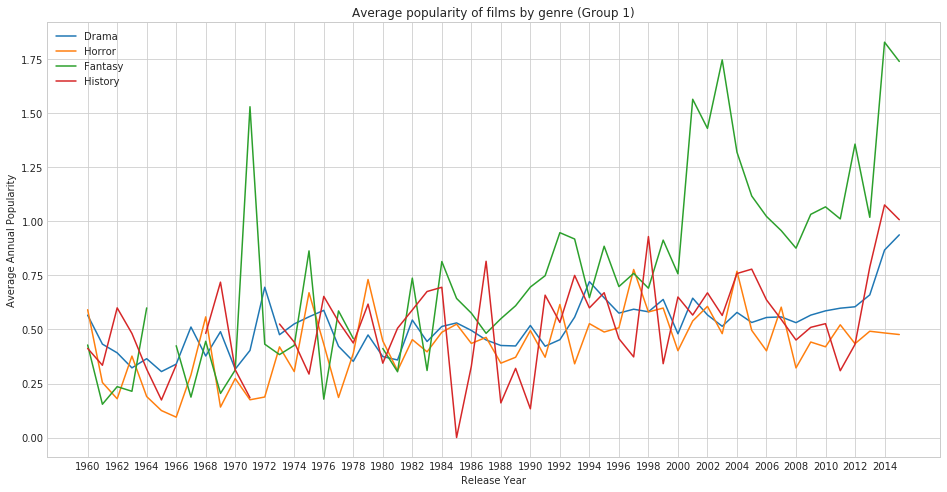

In [48]:
# group 1: drama, horror, fantasy and history
fig, ax = plt.subplots(figsize=(16, 8))
plt.title('Average popularity of films by genre (Group 1)')
plt.ylabel('Average Annual Popularity')
plt.xlabel('Release Year')
plt.xticks(np.arange(1960, 2016, 2))
ax.plot('release_year', 'popularity_drama', data=genre_merge, label="Drama")
ax.plot('release_year', 'popularity_horror', data=genre_merge, label="Horror")
ax.plot('release_year', 'popularity_fantasy', data=genre_merge, label="Fantasy")
ax.plot('release_year', 'popularity_history', data=genre_merge, label="History")
ax.legend(loc='upper left');

In [49]:
# compare close line graphs
genre_merge.loc[:, ['popularity_mystery', 'popularity_war']].mean()

popularity_mystery                   0.57
popularity_war                       0.63
dtype: float64

<a id='eda'></a>
Group 2
Comedy appears to be the least popular within this group and generally tracks below adventure and war. Mystery has a strong peak in 1968, but can be seen to be less popular than adventure and of a comparable popularity with war.

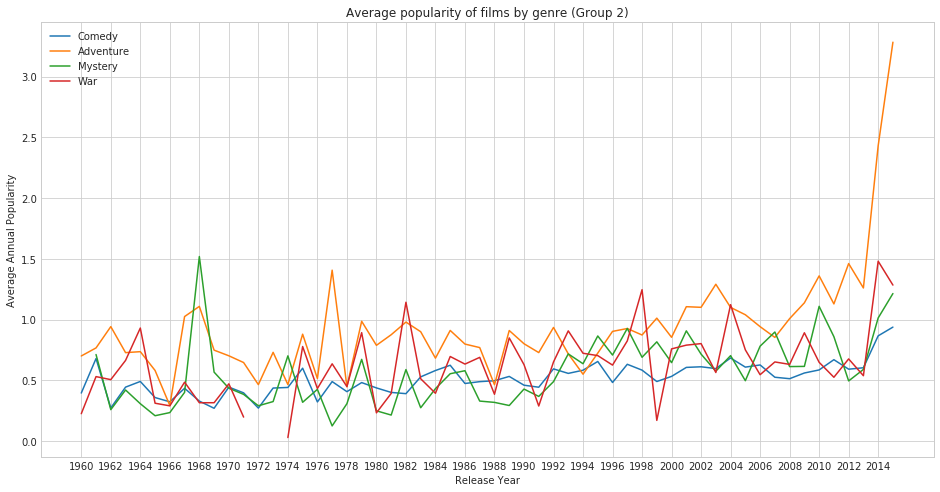

In [50]:
# group 2: comedy, adventure, mystery, war
fig, ax = plt.subplots(figsize=(16, 8))
plt.title('Average popularity of films by genre (Group 2)')
plt.ylabel('Average Annual Popularity')
plt.xlabel('Release Year')
plt.xticks(np.arange(1960, 2016, 2))
ax.plot('release_year', 'popularity_comedy', data=genre_merge, label="Comedy")
ax.plot('release_year', 'popularity_adventure', data=genre_merge, label="Adventure")
ax.plot('release_year', 'popularity_mystery', data=genre_merge, label="Mystery")
ax.plot('release_year', 'popularity_war', data=genre_merge, label="War")
ax.legend(loc='upper left');

In [51]:
genre_merge.loc[:, ['popularity_thriller', 'popularity_crime']].mean()

popularity_thriller                   0.65
popularity_crime                      0.64
dtype: float64

<a id='eda'></a>
Group 3
The lack of data points makes the foreign genre hard to compare, so for this analysis we will dicsount it. Animation also lacks some data points around the early 1960s and sporadically between 1975 and 1981, however where it does occur it gives a strong indication that this is a popular genre. Thriller and crime generally track quite similarly to each other, with thriller edging only slightly above.

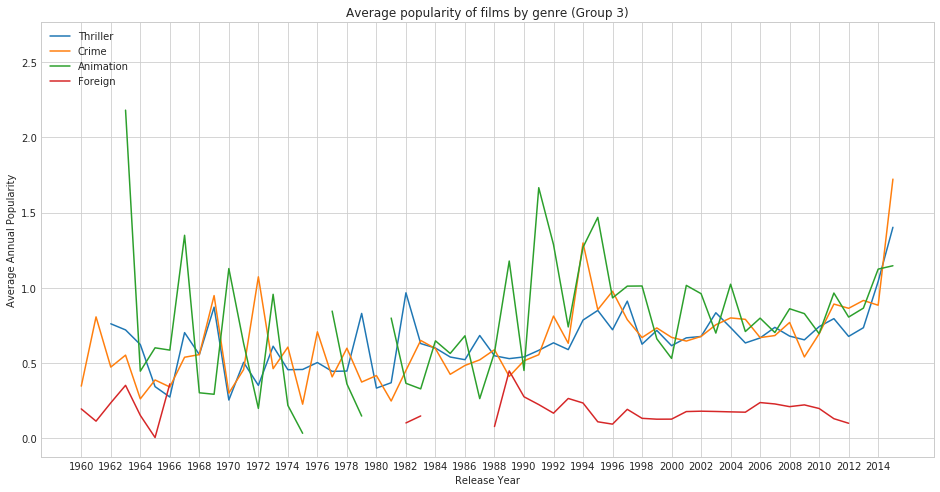

In [52]:
# group 3: thriller, crime, animation, foreign
fig, ax = plt.subplots(figsize=(16, 8))
plt.title('Average popularity of films by genre (Group 3)')
plt.ylabel('Average Annual Popularity')
plt.xlabel('Release Year')
plt.xticks(np.arange(1960, 2016, 2))
ax.plot('release_year', 'popularity_thriller', data=genre_merge, label="Thriller")
ax.plot('release_year', 'popularity_crime', data=genre_merge, label="Crime")
ax.plot('release_year', 'popularity_animation', data=genre_merge, label="Animation")
ax.plot('release_year', 'popularity_foreign', data=genre_merge, label="Foreign")
ax.legend(loc='upper left');

In [53]:
genre_merge.loc[:, ['popularity_action', 'popularity_family']].mean()

popularity_action                   0.76
popularity_family                   0.69
dtype: float64

<a id='eda'></a>
Group 4
Again, we have a situation where some genres (documentary and tv movie) are lacking too many data points, though even with the data we have, they are tracking low against the others. Action and family are both strong in this group, with action (when comparing the average popularity of both genres across all years) suggesting to be more popular with audiences overall.

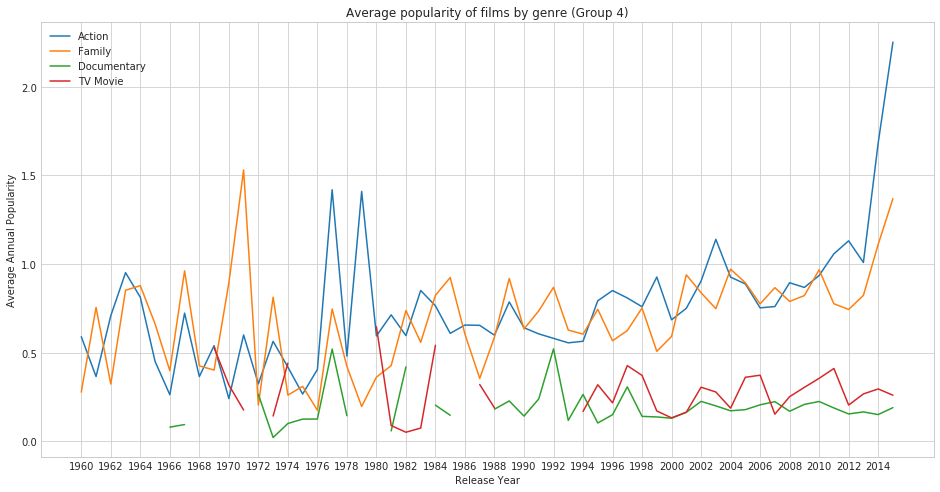

In [54]:
# group 4: action, family, documentary, tv movie
fig, ax = plt.subplots(figsize=(16, 8))
plt.title('Average popularity of films by genre (Group 4)')
plt.ylabel('Average Annual Popularity')
plt.xlabel('Release Year')
plt.xticks(np.arange(1960, 2016, 2))
ax.plot('release_year', 'popularity_action', data=genre_merge, label="Action")
ax.plot('release_year', 'popularity_family', data=genre_merge, label="Family")
ax.plot('release_year', 'popularity_documentary', data=genre_merge, label="Documentary")
ax.plot('release_year', 'popularity_tv movie', data=genre_merge, label="TV Movie")
ax.legend(loc='upper left');

In [55]:
# compare close line graphs
genre_merge.loc[:, ['popularity_action', 'popularity_family']].mean()

popularity_action                   0.76
popularity_family                   0.69
dtype: float64

<a id='eda'></a>
Group 5
Science fiction is the strongest contender in this group, while the western genre has too many data points missing. While romance and music appear to track quite similarly on the graph, it is only when we also look at their overall popularity through the years that we see that romance is generally higher.

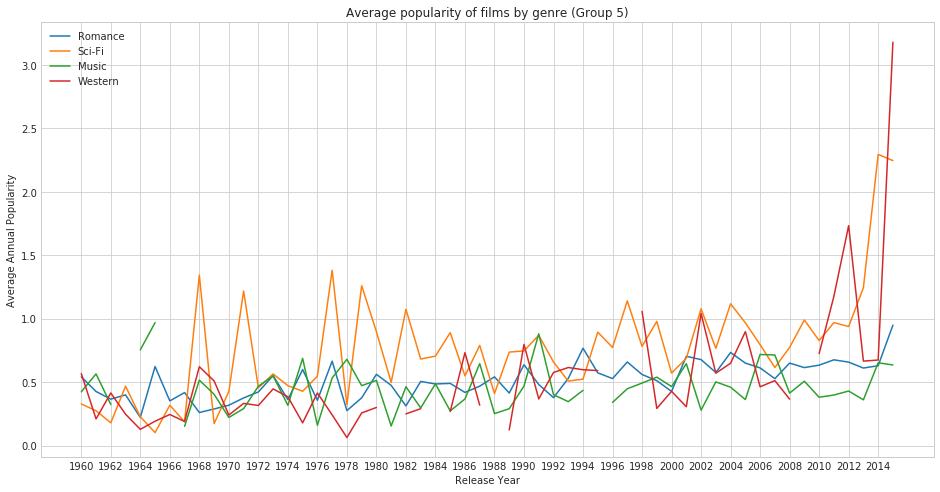

In [56]:
# group 5: romance, sci-fi, music, western
fig, ax = plt.subplots(figsize=(16, 8))
plt.title('Average popularity of films by genre (Group 5)')
plt.ylabel('Average Annual Popularity')
plt.xlabel('Release Year')
plt.xticks(np.arange(1960, 2016, 2))
ax.plot('release_year', 'popularity_romance', data=genre_merge, label="Romance")
ax.plot('release_year', 'popularity_science fiction', data=genre_merge, label="Sci-Fi")
ax.plot('release_year', 'popularity_music', data=genre_merge, label="Music")
ax.plot('release_year', 'popularity_western', data=genre_merge, label="Western")
ax.legend(loc='upper left');

In [57]:
genre_merge.loc[:, ['popularity_romance', 'popularity_music']].mean()

popularity_romance                   0.51
popularity_music                     0.46
dtype: float64

<a id='eda'></a>
The Final Graph
The final graph will take a look at the most popular in each group and compare these together:

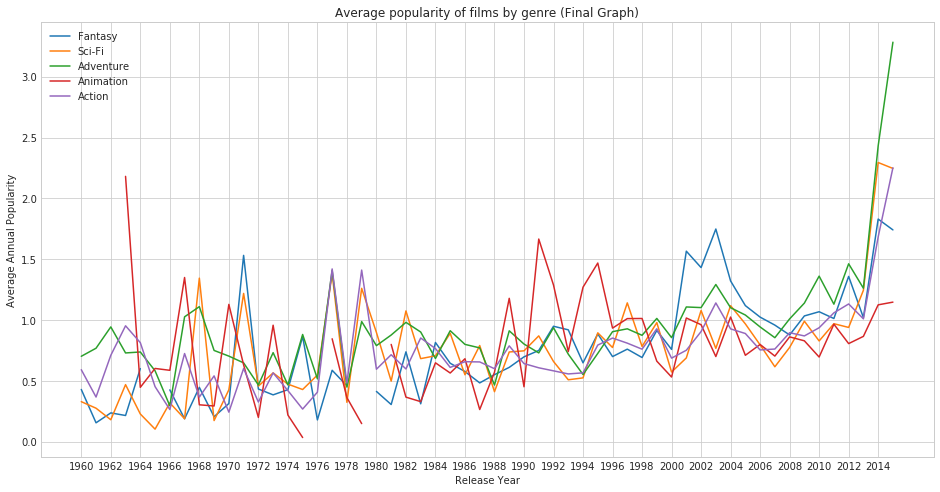

In [58]:
#Final Graph
fig, ax = plt.subplots(figsize=(16, 8))
plt.title('Average popularity of films by genre (Final Graph)')
plt.ylabel('Average Annual Popularity')
plt.xlabel('Release Year')
plt.xticks(np.arange(1960, 2016, 2))
ax.plot('release_year', 'popularity_fantasy', data=genre_merge, label="Fantasy")
ax.plot('release_year', 'popularity_science fiction', data=genre_merge, label="Sci-Fi")
ax.plot('release_year', 'popularity_adventure', data=genre_merge, label="Adventure")
ax.plot('release_year', 'popularity_animation', data=genre_merge, label="Animation")
ax.plot('release_year', 'popularity_action', data=genre_merge, label="Action")
ax.legend(loc='upper left');

In [59]:
genre_merge.loc[:, ['popularity_animation', 'popularity_action', 'popularity_science fiction', 'popularity_fantasy', 'popularity_adventure']].mean()

popularity_animation                         0.82
popularity_action                            0.76
popularity_science fiction                   0.76
popularity_fantasy                           0.76
popularity_adventure                         0.94
dtype: float64

### Research Question 2  (What kinds of properties are associated with films that have high revenues?)

In [60]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investigate.


In [61]:
movies.head(5)

,id,popularity,original_title,cast,director,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,32.99,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,2015-06-09,5562,6.50,2015,"137,999,939.28","1,392,445,892.52"
1,76341,28.42,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,George Miller,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,2015-05-13,6185,7.10,2015,"137,999,939.28","348,161,292.49"
2,262500,13.11,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,Robert Schwentke,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,2015-03-18,2480,6.30,2015,"101,199,955.47","271,619,025.41"
3,140607,11.17,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,J.J. Abrams,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,2015-12-15,5292,7.50,2015,"183,999,919.04","1,902,723,129.80"
4,168259,9.34,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,James Wan,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,2015-04-01,2947,7.30,2015,"174,799,923.09","1,385,748,801.47"


In [62]:
cast_list = movies['cast'].str.split('|').tolist()
cast_list[:5]

[['Chris Pratt',
  'Bryce Dallas Howard',
  'Irrfan Khan',
  "Vincent D'Onofrio",
  'Nick Robinson'],
 ['Tom Hardy',
  'Charlize Theron',
  'Hugh Keays-Byrne',
  'Nicholas Hoult',
  'Josh Helman'],
 ['Shailene Woodley',
  'Theo James',
  'Kate Winslet',
  'Ansel Elgort',
  'Miles Teller'],
 ['Harrison Ford',
  'Mark Hamill',
  'Carrie Fisher',
  'Adam Driver',
  'Daisy Ridley'],
 ['Vin Diesel',
  'Paul Walker',
  'Jason Statham',
  'Michelle Rodriguez',
  'Dwayne Johnson']]

In [63]:
type(cast_list[0][0])

str

In [64]:
cast_list_two = []

def cast_list_func(x, empty_list):
    counter = 0
    for i in x:
        empty_list.append(x[counter][0])
        counter += 1

In [65]:
cast_list_two[:5]

[]

In [66]:
# drop colums for question 2
movies.drop(['popularity', 'genres', 'production_companies', 'vote_count', 'vote_average', 'release_year'], axis=1, inplace=True)

<a id='conclusions'></a>
## Conclusions

Question 1 : Which genres are most popular from year to year?

Answer 1 : As a result of analyzing the data in the graph, the advancement of the Adventure genre was noticeable, and the popularity of the Animation genre also increased significantly over time. However, the volume of Average Anuual Popluatrity of the Animation genre is the lowest among the five genres.

Quesiton 2: What kinds of properties are associated with films that have high revenues?

Answer 2 : As a result of analyzing the given data, movies of action and adventure genres are advantageous for good box office success, and movies with a running time of 2 to 2 hours and 10 minutes are advantageous. 

Limitations : However, since this analysis was performed with past data, it is difficult to conclude that it is an accurate prediction because the correlation with future data is unknown.



## Submitting your Project 

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [67]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0